In [1]:
import random

random_seed = 10
random.seed(random_seed)

In [2]:
!pip install gensim

In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from google.colab import drive
drive.mount('/content/gdrive')


#Shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
df

Mounted at /content/gdrive


,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,426,Wilmar International,NaN,Closed,8/19/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Sumatra Jaya Agro Lestari (SJAL), a subsidiary...",NaN,NaN,NaN,Alleged construction of canal to prepare for d...,Dialogue initiated with PT Sumatra Jaya Agro L...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN
426,427,Wilmar International,NaN,Closed,7/1/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Patiware, a subsidiary of GAMA Plantation",NaN,NaN,NaN,NaN,Dialogue initiated with Ganda Group on the fir...,http://www.greenomics.org/docs/The%20Grievance...,NaN
427,428,Wilmar International,NaN,Closed,5/30/2015,NaN,NaN,NaN,NaN,Action Network - Forest Heroes,Setia Agrindo Lestari (SAL) an affiliate* of F...,NaN,NaN,NaN,NaN,Dialogue initiated with First Resources in the...,https://www.thejakartapost.com/news/2015/05/12...,NaN
428,429,Wilmar International,NaN,Closed,6/5/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,Sawit Sumbermas Sarana (SSS),NaN,NaN,NaN,Alleged clearance of potential High Carbon Sto...,Following a couple of NGO reports about Sawit ...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN


In [4]:
#import modules
import os.path
import re
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# LSA Model Creation Functions

## load_data_from_dataframe

In [5]:
def load_data_from_dataframe(df_column):
    """
    Input  : Pandas Series (e.g., grievances_df['summary'])
    Purpose: Load text data from a DataFrame column
    Output : list of documents and list of titles (first 100 characters)
    """
    documents_list = df_column.dropna().tolist()
    titles = [doc[:100] for doc in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

In [6]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## preprocess_data

In [7]:
# NO LEMMATIZATION

stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges', 'area']

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    # create English stop words list
    en_stop = set(stopwords.words('english') + stopwords_extra)

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        print(i)
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


## prepare_corpus

In [8]:
from gensim.models import TfidfModel

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus, converting list of documents (corpus) into Document Term Matrix,
             and applying TF-IDF weighting.
    Output : term dictionary, TF-IDF weighted Document Term Matrix, and TF-IDF model
    """
    # Creating the term dictionary of our corpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Applying TF-IDF weighting
    tfidf_model = TfidfModel(doc_term_matrix)
    tfidf_matrix = tfidf_model[doc_term_matrix]

    # generate LDA model
    return dictionary, tfidf_matrix, tfidf_model

## create_gensim_lsa_model

In [9]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary, tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)

    lsamodel = LsiModel(tfidf_matrix,
                        num_topics=number_of_topics,
                        id2word = dictionary,
                        random_seed=1
                        # ,chunksize=10
                        # ,power_iters=10
                        )
    return lsamodel

## Compute Coherence Values

In [10]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary, random_seed=1)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Coherence Predictions



In [11]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, tfidf_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Load and preprocess the data to create clean_text
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text = preprocess_data(document_list)


start,stop,step=2,12,1

Total Number of Documents: 387
That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.
The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges th

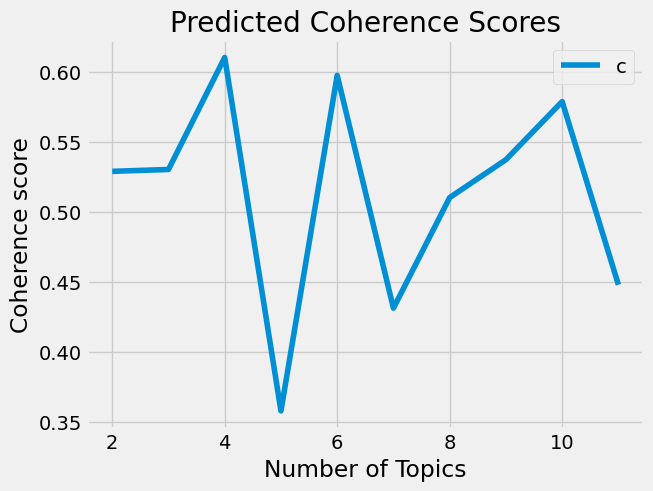

In [12]:
plt.title("Predicted Coherence Scores")

plot_graph(clean_text,start,stop,step)

# Model Creation

In [13]:
summary = df['summary'].dropna().tolist()

# LSA Model
number_of_topics = 7
words = 10
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text=preprocess_data(document_list)
lsamodel=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 387
That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.
The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges th

## Raw Results

In [14]:
for i, topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
    print(f"Topic {i}: {topic}\n")

Topic 0: -0.231*"eof" + -0.182*"plantat" + -0.167*"forest" + -0.157*"illeg" + -0.148*"gar" + -0.147*"investig" + -0.144*"mill" + -0.127*"earth" + -0.126*"mighti" + -0.125*"rapid"

Topic 1: 0.251*"eof" + -0.221*"mighti" + -0.220*"rapid" + -0.219*"earth" + -0.202*"indic" + -0.201*"ha" + -0.191*"respons" + -0.168*"deforest" + -0.162*"concess" + 0.152*"illeg"

Topic 2: 0.215*"land" + 0.184*"right" + 0.180*"worker" + -0.155*"rapid" + -0.154*"mighti" + 0.150*"violat" + -0.147*"earth" + 0.138*"labour" + -0.135*"indic" + 0.123*"alleg"

Topic 3: -0.358*"park" + -0.333*"cpo" + -0.316*"ffb" + -0.266*"nation" + -0.266*"bukit" + -0.209*"contamin" + -0.191*"nilo" + -0.191*"tesso" + -0.191*"tigapuluh" + -0.184*"betabuh"

Topic 4: 0.408*"biodivers" + 0.380*"leuser" + 0.340*"clearanc" + 0.320*"ecosystem" + 0.299*"impact" + 0.214*"forest" + 0.210*"potenti" + 0.141*"stock" + 0.134*"carbon" + 0.116*"hc"

Topic 5: -0.219*"link" + -0.195*"jaya" + -0.190*"suppli" + -0.188*"chain" + 0.165*"ha" + -0.163*"green

# Coherence Score

In [15]:
dictionary, _ , _ = prepare_corpus(clean_text)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("CV: ", coherence_score)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
print("UMASS: ", coherence_score)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='c_uci')
coherence_score = coherence_model.get_coherence()
print("CUCI: ", coherence_score)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='c_npmi')
coherence_score = coherence_model.get_coherence()
print("CNPMI: ", coherence_score)

CV:  0.4313038040706992
UMASS:  -5.094035325430307
CUCI:  -6.984152566626299
CNPMI:  -0.1588403779835468


# Visualizations



In [16]:
model_name = "LSA"

## Create Dataframe with Results

In [17]:
#Input: LSA model, corpus (in this case TFIDF matrix), text (summary column)
#Output: Dataframe consisting of every row
def format_topics_sentences(model=None, corpus=None, texts=None):
    # Collect rows in a list
    rows = []

    for i, doc in enumerate(model[corpus]):
        # Create Dict for Topic contributions, and normalize values
        total_weight = sum(abs(weight) for _, weight in doc)
        topic_dist = {
            f"Topic_{topic_id}_Perc": round((abs(weight) / total_weight) * 100, 2) # Finds and normalizes weights for each topic
            for topic_id, weight in doc
        }

        # Create Dict for Multi-Label Binary Classifcation
        topic_binary = {
            f"Topic_{topic_id}": 0
            for topic_id, weight in doc
        }

        shared_perc = 0 # Shared contribution amongst topics given to document
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)
        dom_topic_num = 0
        dom_topic_perc = 0.0
        is_outlier = False

        # Get Dominant Topics
        itr = 0
        while (shared_perc < 50.0):
            # Get Topic Number and Topic Percentage
            topic_num, topic_perc = sorted_doc[itr]
            topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
            shared_perc += topic_perc
            topic_binary[f"Topic_{topic_num}"] = 1  # Multi-Label Binary Classifcation

            # Get Prime Dominant Topic
            if itr == 0:
                dom_topic_num = topic_num
                dom_topic_perc = topic_perc
            itr += 1

            # Check if Outlier
            if (itr) > (number_of_topics/2):
                is_outlier = True

        topic_keywords = ", ".join([word for word, _ in model.show_topic(dom_topic_num)])

        # Create Row for Document
        row = {
            'Dominant_Topic': int(dom_topic_num),
            'Perc_Contribution': dom_topic_perc,
            'Topic_Keywords': topic_keywords,
            'Text': texts[i],
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row.update(topic_dist) # Add individual topic contributions
        row.update(topic_binary) # Add Multi-Label Binary Classifcation for topics
        rows.append(row)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [18]:
# Grab TFIDF matrix from prev functions
_ , tfidf_matrix , _ = prepare_corpus(clean_text)

# Format
dominant_topic_df = format_topics_sentences(model=lsamodel, corpus=tfidf_matrix, texts=document_list).reset_index()
dominant_topic_df.head()

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,...,Topic_4_Perc,Topic_5_Perc,Topic_6_Perc,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,0,2,31.74,"land, right, worker, rapid, mighti, violat, ea...",That the Respondent allegedly transferred the ...,False,2,9.01,4.55,31.74,...,15.96,6.73,29.89,0,0,1,0,0,0,1
1,1,2,35.89,"land, right, worker, rapid, mighti, violat, ea...",The Complainant alleges that the Respondent ha...,False,2,15.32,2.65,35.89,...,14.79,6.36,24.53,0,0,1,0,0,0,1
2,2,2,37.96,"land, right, worker, rapid, mighti, violat, ea...",1.The Complainant alleges that the Respondent ...,False,2,20.84,9.38,37.96,...,5.24,0.53,18.83,1,0,1,0,0,0,0
3,3,0,28.07,"eof, plantat, forest, illeg, gar, investig, mi...",The Respondent's Corporate Social Responsibili...,False,2,28.07,7.88,26.20,...,13.12,5.40,12.90,1,0,1,0,0,0,0
4,4,2,28.27,"land, right, worker, rapid, mighti, violat, ea...",The Complainant alleges that the Respondent br...,False,3,18.67,10.15,28.27,...,16.14,4.59,12.79,1,0,1,0,1,0,0


In [19]:
# Convert to CSV and save
dominant_topic_df.to_csv("LSA_results.csv",index = False)
from google.colab import files
# files.download("LSA_results.csv")

## Data Exploration

In [20]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 5].sort_values(by='Perc_Contribution', ascending=False)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,...,Topic_4_Perc,Topic_5_Perc,Topic_6_Perc,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
200,200,5,53.81,"link, jaya, suppli, chain, ha, greenpeac, raya...","In report ""A Deadly Trade-Off"" Greenpeace repo...",False,1,23.29,15.76,4.20,...,1.10,53.81,1.20,0,0,0,0,0,1,0
231,231,5,52.77,"link, jaya, suppli, chain, ha, greenpeac, raya...","In the report ""A Deadly Trade-Off"", Greenpeace...",False,1,20.62,6.33,4.70,...,2.98,52.77,5.31,0,0,0,0,0,1,0
201,201,5,52.77,"link, jaya, suppli, chain, ha, greenpeac, raya...","In report ""A Deadly Trade-Off"", Greenpeace sai...",False,1,20.62,6.33,4.70,...,2.98,52.77,5.31,0,0,0,0,0,1,0
178,178,5,51.21,"link, jaya, suppli, chain, ha, greenpeac, raya...",Allegations of forest clearing by palm oil sup...,False,1,25.75,16.07,3.54,...,1.47,51.21,0.84,0,0,0,0,0,1,0
358,358,5,50.42,"link, jaya, suppli, chain, ha, greenpeac, raya...",Alleged deforestation by PT Gerbang Benua Raya...,False,1,21.03,14.62,9.43,...,0.89,50.42,1.47,0,0,0,0,0,1,0
355,355,5,46.52,"link, jaya, suppli, chain, ha, greenpeac, raya...",Non-compliant palm products from PT Indo Alam ...,False,2,21.90,2.97,5.05,...,0.42,46.52,14.36,1,0,0,0,0,1,0
357,357,5,43.65,"link, jaya, suppli, chain, ha, greenpeac, raya...",Non-compliant palm products from Amanah Saham ...,False,2,15.13,5.76,6.60,...,6.15,43.65,12.32,1,0,0,0,0,1,0
370,370,5,43.53,"link, jaya, suppli, chain, ha, greenpeac, raya...",Non-compliant palm products from Alas Kusuma a...,False,2,15.35,5.79,5.53,...,5.01,43.53,13.73,1,0,0,0,0,1,0
365,365,5,43.45,"link, jaya, suppli, chain, ha, greenpeac, raya...","Alleged deforestation by Rendi Permata Raya, a...",False,2,30.14,10.61,12.14,...,0.35,43.45,2.19,1,0,0,0,0,1,0
371,371,5,42.44,"link, jaya, suppli, chain, ha, greenpeac, raya...",Non-compliant palm products allegedly enter Wi...,False,2,16.62,7.52,4.53,...,4.77,42.44,13.56,1,0,0,0,0,1,0


## Avg Dominant Topic Contribution

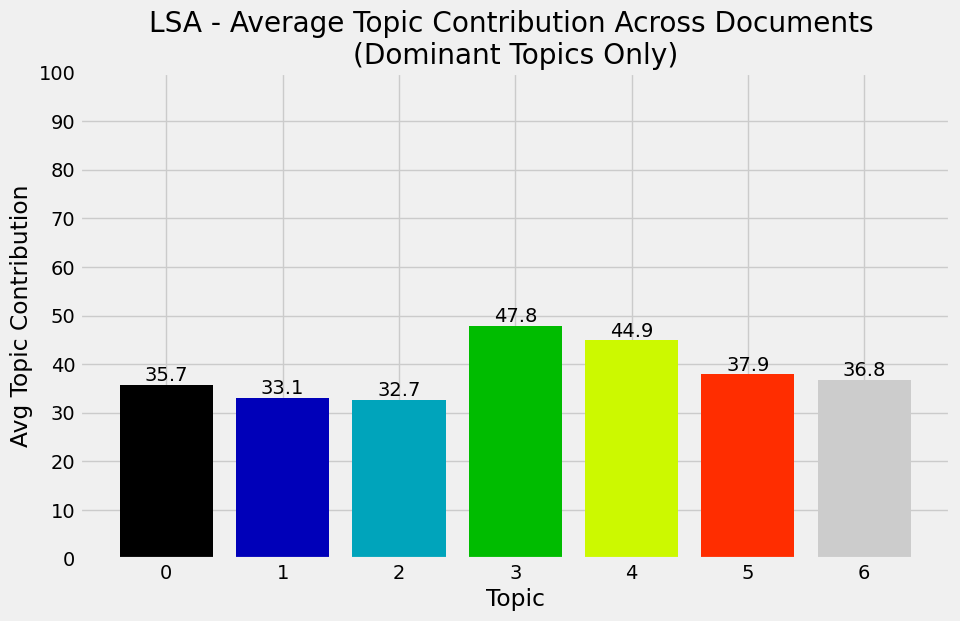

In [21]:
# Prepare data
topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Perc_Contribution'].round(1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Average Topic Contribution Across Documents \n(Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution')
plt.xticks(indexes)
plt.yticks(range(0,101,10))
plt.show()

## Dominant Topic Frequency

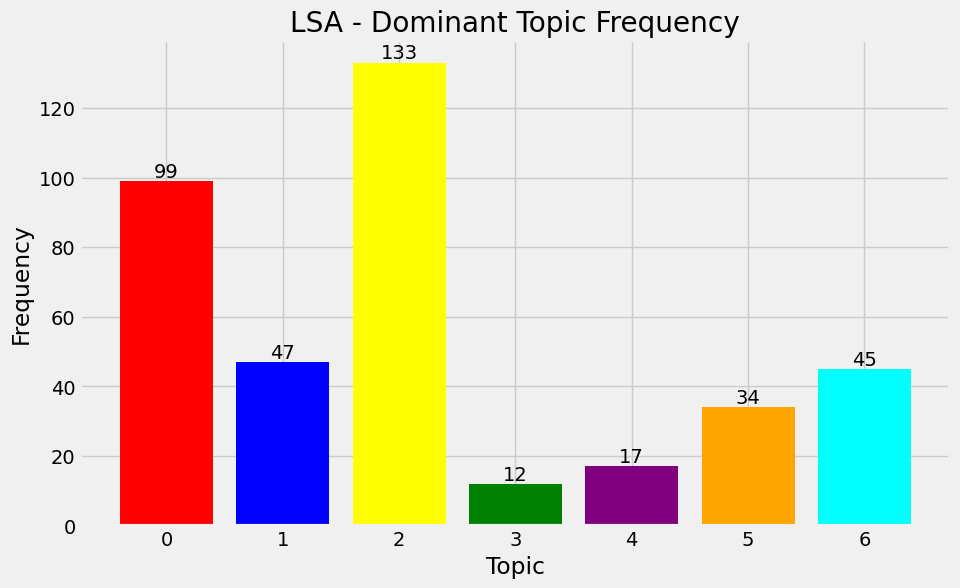

In [22]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['index'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['index']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Topic Distribution per Doc

In [23]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['index'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

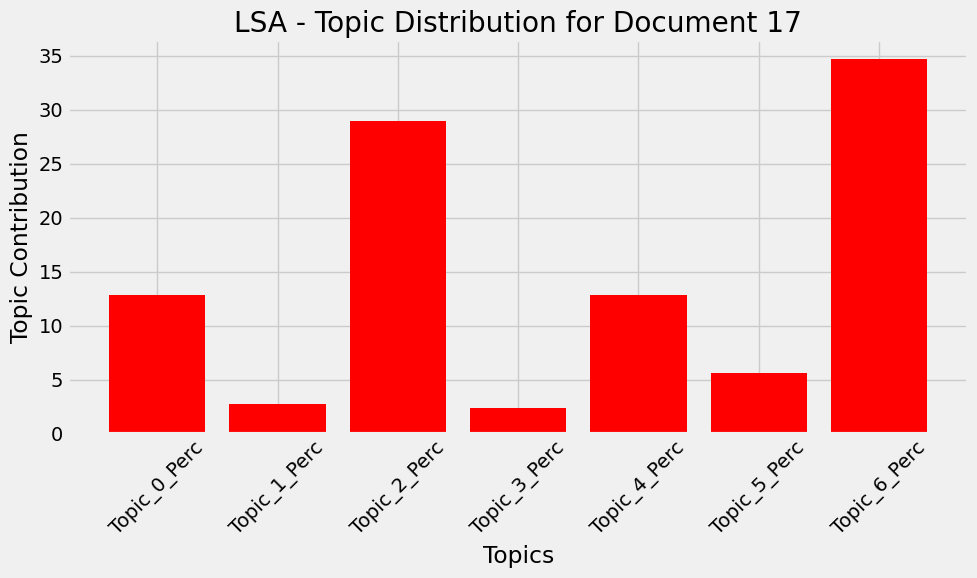

In [24]:
topic_dist_doc(dominant_topic_df, number_of_topics, 17)

## Wordclouds

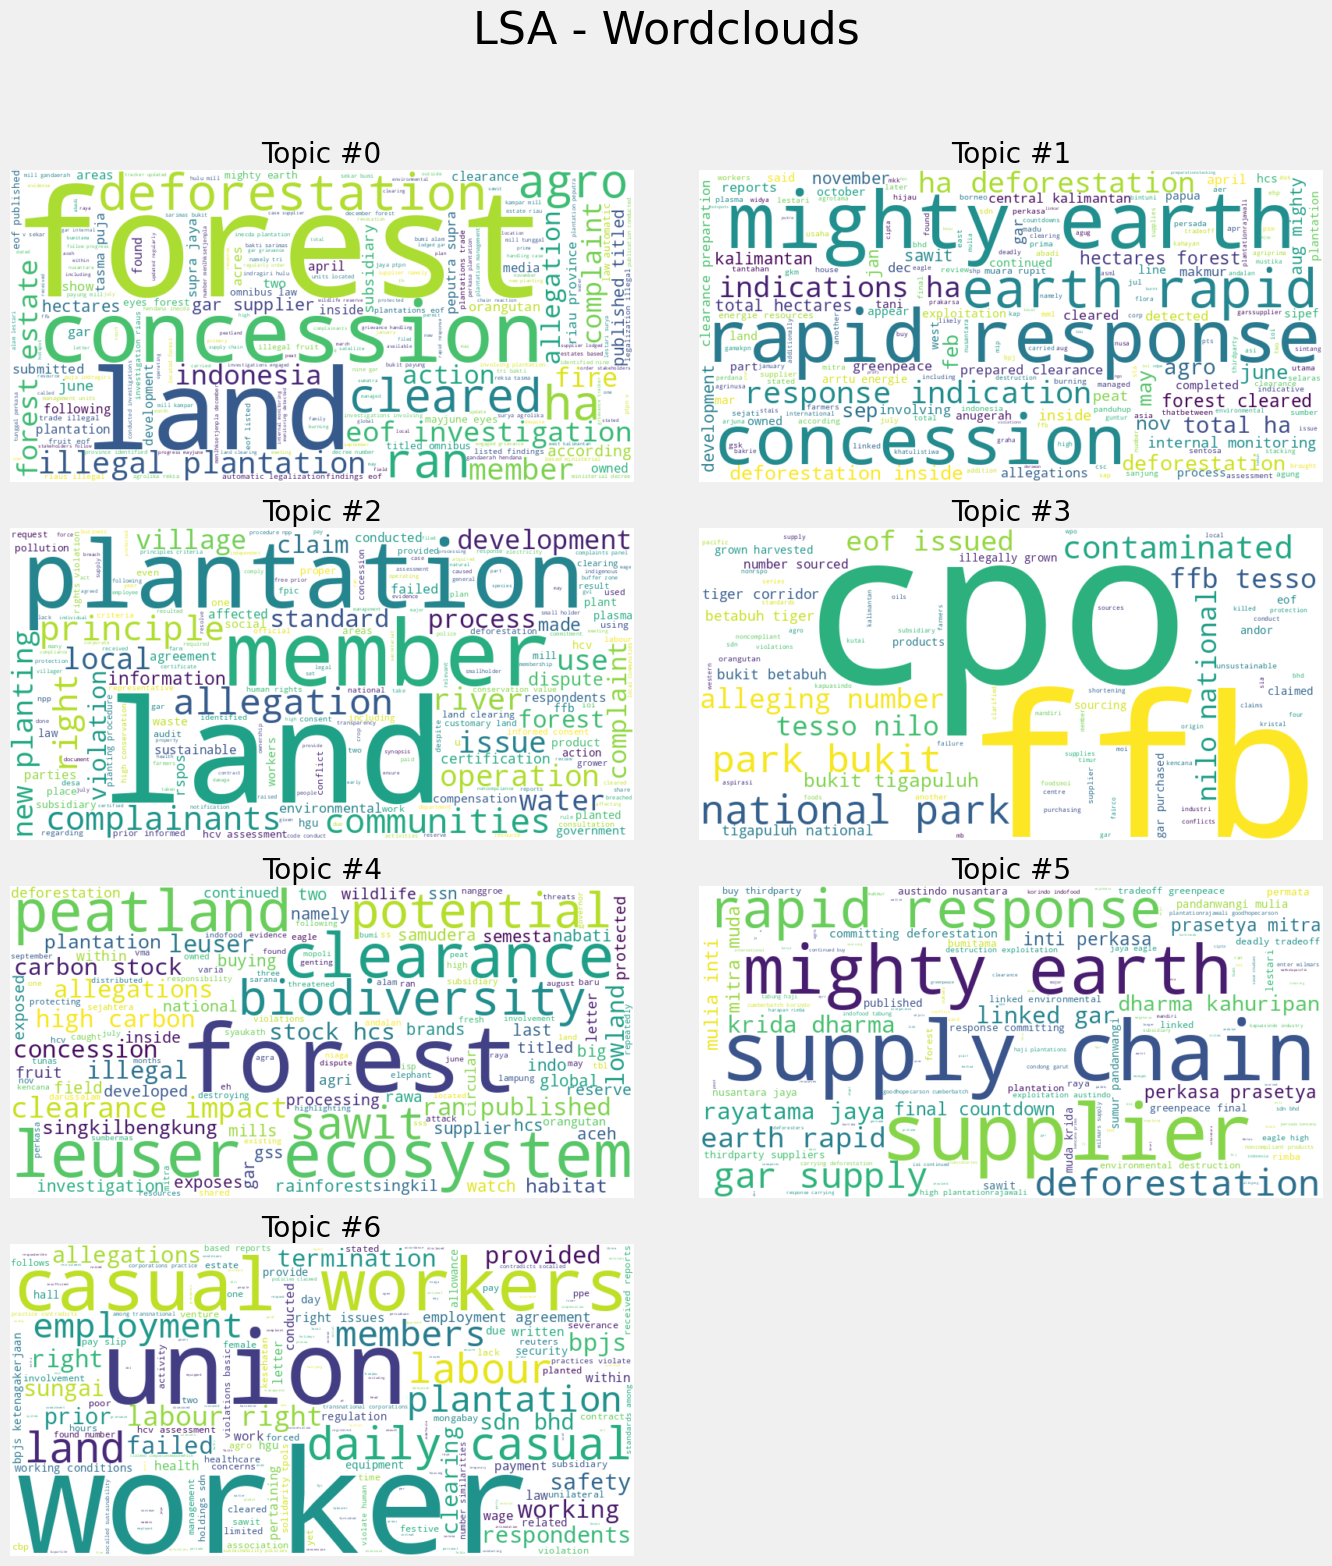

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordclouds', n_topics=number_of_topics)

### Wordcloud for Misc Workers

In [26]:
misc_workers_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 2]
misc_workers_df = misc_workers_df[misc_workers_df['Topic_6'] == 1]
misc_workers_df

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,...,Topic_4_Perc,Topic_5_Perc,Topic_6_Perc,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,0,2,31.74,"land, right, worker, rapid, mighti, violat, ea...",That the Respondent allegedly transferred the ...,False,2,9.01,4.55,31.74,...,15.96,6.73,29.89,0,0,1,0,0,0,1
1,1,2,35.89,"land, right, worker, rapid, mighti, violat, ea...",The Complainant alleges that the Respondent ha...,False,2,15.32,2.65,35.89,...,14.79,6.36,24.53,0,0,1,0,0,0,1
6,6,2,25.08,"land, right, worker, rapid, mighti, violat, ea...",The Respondent has allegedly conducted land cl...,False,3,21.22,8.26,25.08,...,8.57,11.07,17.91,1,0,1,0,0,0,1
8,8,2,36.82,"land, right, worker, rapid, mighti, violat, ea...",The Complainant alleges that the Respondent is...,False,2,15.16,7.53,36.82,...,15.27,4.62,16.26,0,0,1,0,0,0,1
11,11,2,38.39,"land, right, worker, rapid, mighti, violat, ea...",Allegations revolve around land issues where t...,False,2,16.09,8.13,38.39,...,4.30,9.16,23.79,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,348,2,33.70,"land, right, worker, rapid, mighti, violat, ea...",Alleged labour rights violation in Sime Darby ...,False,2,16.91,2.67,33.70,...,15.43,3.28,20.98,0,0,1,0,0,0,1
353,353,2,34.68,"land, right, worker, rapid, mighti, violat, ea...",Alleged labour rights violation in PT Dewa Ren...,False,2,11.07,5.57,34.68,...,13.95,0.19,29.25,0,0,1,0,0,0,1
354,354,2,28.73,"land, right, worker, rapid, mighti, violat, ea...","Alleged land rights, labour rights violations ...",False,3,16.32,12.84,28.73,...,10.74,9.69,17.99,1,0,1,0,0,0,1
364,364,2,32.59,"land, right, worker, rapid, mighti, violat, ea...",Allegations of land rights and labour rights v...,False,2,17.57,13.69,32.59,...,8.49,3.67,21.23,0,0,1,0,0,0,1


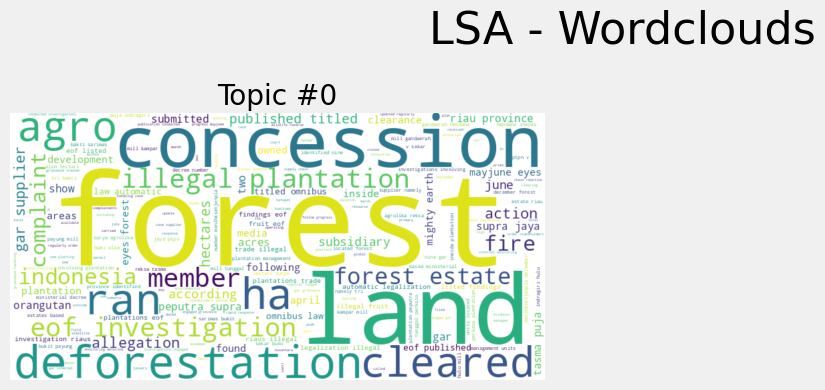

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()




display_wordcloud(df=misc_workers_df, title=f'{model_name} - Wordclouds', n_topics=1)

## Overall Dominant Topic % share

Text(0, 0.5, 'Number of Documents')

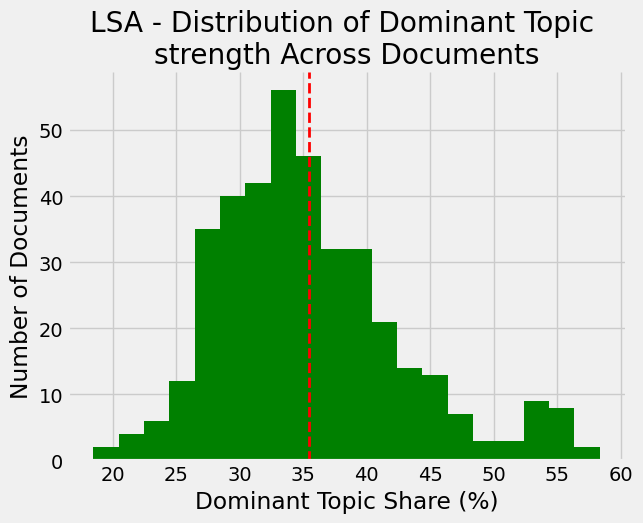

In [28]:
# Displays every doc's dominant topic share as a percentage compared to its other non-dominant topics
# Basically how much weight the dominant topic have throughout each of the documents
dominant_topic_df['Perc_Contribution'].plot(kind='hist', bins=20, title='Perc_Contribution', color='green')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.title(f"{model_name} - Distribution of Dominant Topic \nstrength Across Documents")

mean_value = dominant_topic_df['Perc_Contribution'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

plt.xlabel("Dominant Topic Share (%)")
plt.ylabel("Number of Documents")